In [82]:
import tensorflow as tf
import numpy as np
import random

from sklearn.metrics import classification_report

from utils.data_utils import get_tf_dataset_loader, walk_through_dir
from utils.viz_utils import (plot_training_history,
                             plot_confusion_matrix)
from utils.callbacks_utils import (get_early_stopping_callback,
                                   get_model_checkpoint_callbacks,
                                   get_tensorboard_callback,
                                   get_reduce_lr_on_plateau_callback)
from tensorflow.keras.applications import EfficientNetB5

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

print("✅ All imports loaded successfully!")
print(f"TensorFlow version: {tf.__version__}")

print("Is GPU built with CUDA?", tf.test.is_built_with_cuda())



✅ All imports loaded successfully!
TensorFlow version: 2.10.0
Is GPU built with CUDA? True


In [83]:
def evaluate_and_plot_confusion_matrix(model, test_loader, model_name="efficientnetb5_v1"):

    print("\nGenerating detailed classification report...")

    class_names = None
    if hasattr(test_loader, 'class_names'):
        class_names = list(test_loader.class_names)
    elif hasattr(test_loader, '_input_dataset') and hasattr(test_loader._input_dataset, 'class_names'):
        class_names = list(test_loader._input_dataset.class_names)
    else:
        raise AttributeError(
            "Could not infer class names from test_loader. ")
    print("Inferred class names:", class_names)

    y_true = []
    y_pred = []

    # Iterate over the test_loader batches
    for i, (batch_images, batch_labels) in enumerate(test_loader):
        batch_images = tf.cast(batch_images, tf.float32)

        predictions = model.predict(
            batch_images,
            batch_size=16,
            verbose=0
        )

        y_true_batch = np.argmax(batch_labels, axis=1)
        y_pred_batch = np.argmax(predictions, axis=1)

        y_true.extend(y_true_batch)
        y_pred.extend(y_pred_batch)

        # Clean up memory
        del batch_images, batch_labels, predictions
        tf.keras.backend.clear_session()
        # Print progress
        if i % 10 == 0:
           print(f"Processed batch {i+1}")

    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    print("\n✅ Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    plot_confusion_matrix(
        y_true,
        y_pred,
        class_names=class_names,
        normalize=False,
        model_name=model_name
    )

In [84]:
IMAGE_SIZE = (256, 256)
INPUT_SHAPE = (*IMAGE_SIZE, 3)
BATCH_SIZE = 32
NUM_CLASSES = 7

In [85]:

TRAIN_DIR  = "data/Teeth_Dataset/Training"
VALIDATION_DIR = "data/Teeth_Dataset/Validation"
TEST_DIR   = "data/Teeth_Dataset/Testing"
print(f"\n[INFO] Walking through training directory: {TRAIN_DIR}")
walk_through_dir(TRAIN_DIR)
print(f"\n[INFO] Walking through validation directory: {VALIDATION_DIR}")
walk_through_dir(VALIDATION_DIR)
print(f"\n[INFO] Walking through testing directory: {TEST_DIR}")
walk_through_dir(TEST_DIR)



[INFO] Walking through training directory: data/Teeth_Dataset/Training
There are 7 directories and 0 images in 'data/Teeth_Dataset/Training'.
There are 0 directories and 480 images in 'data/Teeth_Dataset/Training\CaS'.
There are 0 directories and 450 images in 'data/Teeth_Dataset/Training\CoS'.
There are 0 directories and 360 images in 'data/Teeth_Dataset/Training\Gum'.
There are 0 directories and 540 images in 'data/Teeth_Dataset/Training\MC'.
There are 0 directories and 324 images in 'data/Teeth_Dataset/Training\OC'.
There are 0 directories and 540 images in 'data/Teeth_Dataset/Training\OLP'.
There are 0 directories and 393 images in 'data/Teeth_Dataset/Training\OT'.

[INFO] Walking through validation directory: data/Teeth_Dataset/Validation
There are 7 directories and 0 images in 'data/Teeth_Dataset/Validation'.
There are 0 directories and 160 images in 'data/Teeth_Dataset/Validation\CaS'.
There are 0 directories and 149 images in 'data/Teeth_Dataset/Validation\CoS'.
There are 0 di

In [86]:
train_data = get_tf_dataset_loader(TRAIN_DIR,
                                   batch_size=BATCH_SIZE,
                                   image_size=IMAGE_SIZE,
                                   shuffle=True,
                                   seed=SEED,
                                   class_mode="categorical").prefetch(buffer_size=tf.data.AUTOTUNE)

validation_data = get_tf_dataset_loader(VALIDATION_DIR,
                                        batch_size=BATCH_SIZE,
                                        image_size=IMAGE_SIZE,
                                        class_mode="categorical").prefetch(buffer_size=tf.data.AUTOTUNE)


test_data = get_tf_dataset_loader(TEST_DIR,
                                  batch_size=BATCH_SIZE,
                                  image_size=IMAGE_SIZE,
                                  class_mode="categorical").prefetch(buffer_size=tf.data.AUTOTUNE)



Found 3087 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.


# **Build EfficientNet Feature Extraction model** 

![Sample image from the dataset](https://blog.roboflow.com/content/images/2024/04/image-1085.webp)




# **Using EfficientNetB5 as the Feature Extractor (No Data Augmentation layer)**

# ![EfficientNetB5 Architecture](https://www.researchgate.net/profile/Mohammad-Khan-353/publication/347866096/figure/fig3/AS:1015482308124673@1619121257499/The-total-architecture-of-EfficientNet-B5-21.jpg)
# 


In [87]:
# EfficientNetB5 Feature Extraction - Version 1
feature_extractor_b5_v1 = EfficientNetB5(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE
)
feature_extractor_b5_v1.trainable = False

inputs_b5_v1 = tf.keras.layers.Input(shape=INPUT_SHAPE, name="input_layer_b5_v1")

# x_b5_v1 = data_augmentation_b5_v1(inputs_b5_v1)
x_b5_v1 = feature_extractor_b5_v1(inputs_b5_v1)

# Head
x_b5_v1_gap = tf.keras.layers.GlobalAveragePooling2D(name="global_avg_pool")(x_b5_v1)
x_b5_v1_gmp = tf.keras.layers.GlobalMaxPooling2D(name="global_max_pool")(x_b5_v1)
x_b5_v1 = tf.keras.layers.Concatenate(name="pooling_concat")([x_b5_v1_gap, x_b5_v1_gmp])

x_b5_v1 = tf.keras.layers.BatchNormalization(name="batch_norm_1_b5_v1")(x_b5_v1)
x_b5_v1 = tf.keras.layers.Dense(512, activation="relu", name="dense_1_b5_v1")(x_b5_v1)
x_b5_v1 = tf.keras.layers.BatchNormalization(name="batch_norm_2_b5_v1")(x_b5_v1)
x_b5_v1 = tf.keras.layers.Dropout(0.5, name="dropout_2_b5_v1")(x_b5_v1)
outputs_b5_v1 = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", dtype='float32',kernel_regularizer=tf.keras.regularizers.l2(0.01) ,name="output_layer_b5_v1")(x_b5_v1)

model_b5_v1 = tf.keras.Model(inputs=inputs_b5_v1, outputs=outputs_b5_v1, name="efficientnetb5_feature_extraction_v1")

model_b5_v1.summary()


Model: "efficientnetb5_feature_extraction_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer_b5_v1 (InputLayer)  [(None, 256, 256, 3  0          []                               
                                )]                                                                
                                                                                                  
 efficientnetb5 (Functional)    (None, 8, 8, 2048)   28513527    ['input_layer_b5_v1[0][0]']      
                                                                                                  
 global_avg_pool (GlobalAverage  (None, 2048)        0           ['efficientnetb5[0][0]']         
 Pooling2D)                                                                                       
                                                               

In [88]:
model_b5_v1.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

In [89]:
callbacks_model_b5_v1 = [
    get_tensorboard_callback(base_dir="logs", experiment_name="efficientnetb5_v2"),
    get_early_stopping_callback(monitor="val_loss", patience=10),
    *get_model_checkpoint_callbacks(model_name="efficientnetb5_v2", checkpoint_dir="model_checkpoint"),
    get_reduce_lr_on_plateau_callback(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-8, verbose=1)
]
history_model_b5_v1 = model_b5_v1.fit(
    train_data,
    epochs=20,
    steps_per_epoch=len(train_data),
    validation_data=validation_data,
    validation_steps=len(validation_data),
    callbacks=callbacks_model_b5_v1
)

[INFO] Saving TensorBoard logs to: logs\efficientnetb5_v2\20250710-030322
Epoch 1/20
97/97 [==============================] - ETA: 0s - loss: 1.4999 - accuracy: 0.6109
Epoch 1: saving model to model_checkpoint\all_epochs\efficientnetb5_v2_checkpoint.h5

Epoch 1: val_loss improved from inf to 0.96311, saving model to model_checkpoint\efficientnetb5_v2_best.h5
97/97 [==============================] - 44s 287ms/step - loss: 1.4999 - accuracy: 0.6109 - val_loss: 0.9631 - val_accuracy: 0.7296 - lr: 0.0010
Epoch 2/20
97/97 [==============================] - ETA: 0s - loss: 0.6450 - accuracy: 0.8163
Epoch 2: saving model to model_checkpoint\all_epochs\efficientnetb5_v2_checkpoint.h5

Epoch 2: val_loss improved from 0.96311 to 0.50509, saving model to model_checkpoint\efficientnetb5_v2_best.h5
97/97 [==============================] - 23s 233ms/step - loss: 0.6450 - accuracy: 0.8163 - val_loss: 0.5051 - val_accuracy: 0.8609 - lr: 0.0010
Epoch 3/20
97/97 [==============================] - ETA: 0

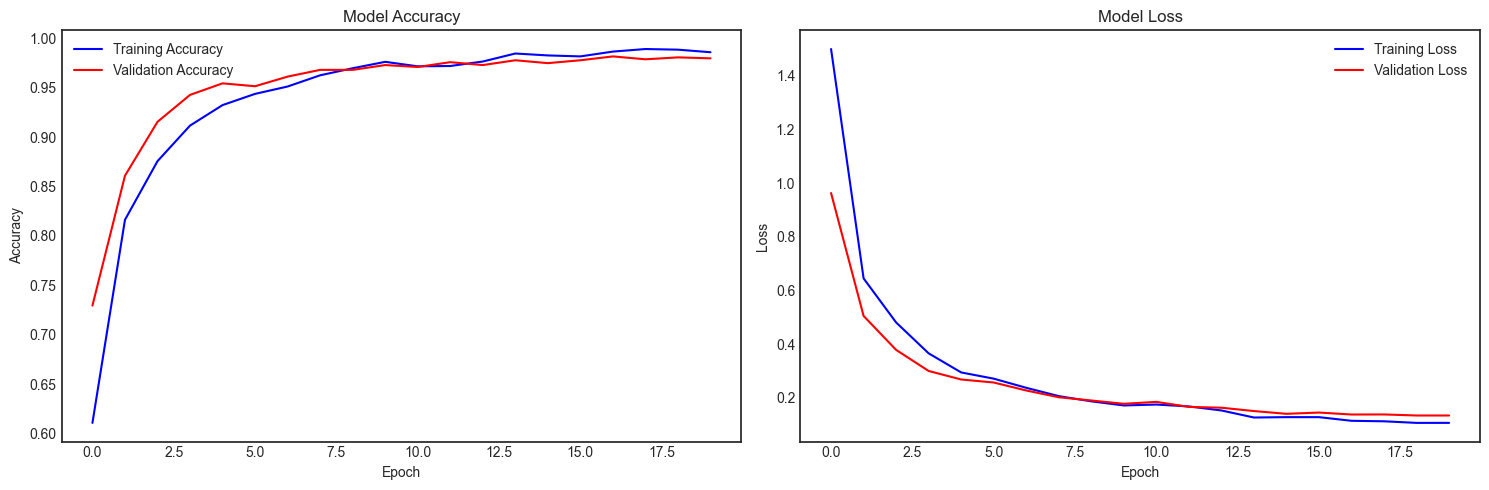

In [90]:
plot_training_history(history_model_b5_v1,"efficientnetb5_v1")


Generating detailed classification report...
Inferred class names: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']
Processed batch 1
Processed batch 11
Processed batch 21
Processed batch 31

✅ Classification Report:

              precision    recall  f1-score   support

         CaS       0.99      0.98      0.99       160
         CoS       0.99      1.00      1.00       149
         Gum       0.98      0.97      0.97       120
          MC       0.98      0.97      0.97       180
          OC       0.97      0.93      0.95       108
         OLP       0.98      0.98      0.98       180
          OT       0.93      0.99      0.96       131

    accuracy                           0.98      1028
   macro avg       0.97      0.97      0.97      1028
weighted avg       0.98      0.98      0.98      1028



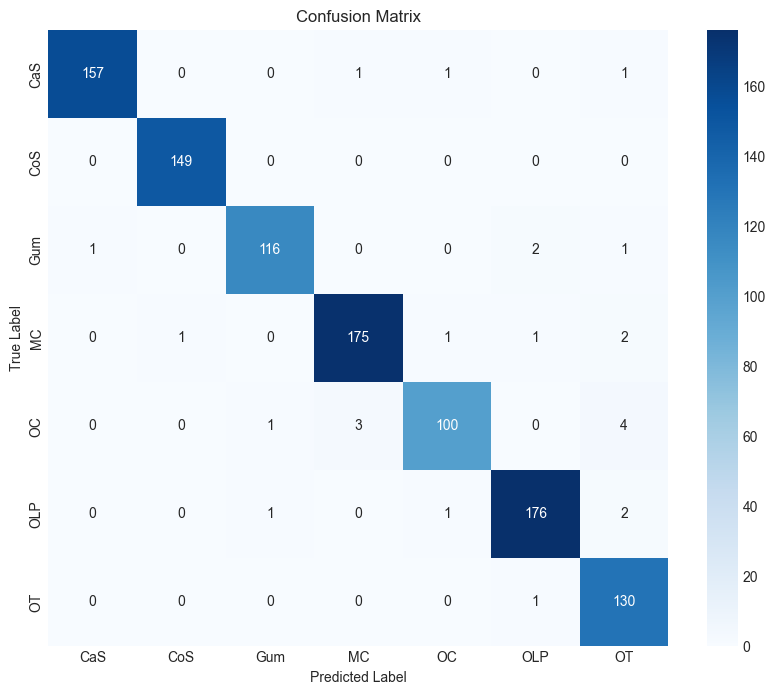

In [91]:
evaluate_and_plot_confusion_matrix(model_b5_v1, test_data, model_name="efficientnetb5_v1")

# **I Will Try To Fine Tune  and UnFroze the last 20 layers as stage 0ne fine tune**

In [92]:
model_b5_v1.load_weights("model_checkpoint/all_epochs/efficientnetb5_v2_checkpoint.h5")

model_b5_v1.summary()


Model: "efficientnetb5_feature_extraction_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer_b5_v1 (InputLayer)  [(None, 256, 256, 3  0          []                               
                                )]                                                                
                                                                                                  
 efficientnetb5 (Functional)    (None, 8, 8, 2048)   28513527    ['input_layer_b5_v1[0][0]']      
                                                                                                  
 global_avg_pool (GlobalAverage  (None, 2048)        0           ['efficientnetb5[0][0]']         
 Pooling2D)                                                                                       
                                                               

In [93]:
model_b5_v1.layers[1].trainable = True
for layer in model_b5_v1.layers[1].layers[:-20]:
    layer.trainable = False

In [94]:
for layer_number, layer in enumerate(model_b5_v1.layers[1].layers):
    print(f"{layer_number} - {layer.name} - {layer.trainable}")

0 - input_1 - False
1 - rescaling - False
2 - normalization - False
3 - rescaling_1 - False
4 - stem_conv_pad - False
5 - stem_conv - False
6 - stem_bn - False
7 - stem_activation - False
8 - block1a_dwconv - False
9 - block1a_bn - False
10 - block1a_activation - False
11 - block1a_se_squeeze - False
12 - block1a_se_reshape - False
13 - block1a_se_reduce - False
14 - block1a_se_expand - False
15 - block1a_se_excite - False
16 - block1a_project_conv - False
17 - block1a_project_bn - False
18 - block1b_dwconv - False
19 - block1b_bn - False
20 - block1b_activation - False
21 - block1b_se_squeeze - False
22 - block1b_se_reshape - False
23 - block1b_se_reduce - False
24 - block1b_se_expand - False
25 - block1b_se_excite - False
26 - block1b_project_conv - False
27 - block1b_project_bn - False
28 - block1b_drop - False
29 - block1b_add - False
30 - block1c_dwconv - False
31 - block1c_bn - False
32 - block1c_activation - False
33 - block1c_se_squeeze - False
34 - block1c_se_reshape - False
3

In [95]:
model_b5_v1.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(lr=1e-5),
    metrics=["accuracy"]
)

callbacks_finetune_b5_v1 = [
    get_tensorboard_callback(base_dir="logs", experiment_name="efficientnetb5_v1_finetune"),
    get_early_stopping_callback(monitor="val_loss", patience=5),
    *get_model_checkpoint_callbacks(
        model_name="efficientnetb5_v1_finetune_stage1",
        checkpoint_dir="model_checkpoint"
    ),
    get_reduce_lr_on_plateau_callback(monitor="val_loss", factor=0.3, patience=5, min_lr=1e-8)
]


[INFO] Saving TensorBoard logs to: logs\efficientnetb5_v1_finetune\20250710-031221


c:\Users\worki\anaconda3\envs\TF3070\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [96]:
TOTAL_EPOCHS=history_model_b5_v1.epoch[-1]+10
history_finetune_b5_v1 = model_b5_v1.fit(
    train_data,
    validation_data=validation_data,
    epochs=TOTAL_EPOCHS,
    initial_epoch=history_model_b5_v1.epoch[-1],
    steps_per_epoch=len(train_data),
    validation_steps=len(validation_data),
    callbacks=callbacks_finetune_b5_v1
)


Epoch 20/29
97/97 [==============================] - ETA: 0s - loss: 0.1128 - accuracy: 0.9848
Epoch 20: saving model to model_checkpoint\all_epochs\efficientnetb5_v1_finetune_stage1_checkpoint.h5

Epoch 20: val_loss improved from inf to 0.12627, saving model to model_checkpoint\efficientnetb5_v1_finetune_stage1_best.h5
97/97 [==============================] - 45s 287ms/step - loss: 0.1128 - accuracy: 0.9848 - val_loss: 0.1263 - val_accuracy: 0.9815 - lr: 1.0000e-05
Epoch 21/29
97/97 [==============================] - ETA: 0s - loss: 0.1046 - accuracy: 0.9867
Epoch 21: saving model to model_checkpoint\all_epochs\efficientnetb5_v1_finetune_stage1_checkpoint.h5

Epoch 21: val_loss improved from 0.12627 to 0.12490, saving model to model_checkpoint\efficientnetb5_v1_finetune_stage1_best.h5
97/97 [==============================] - 23s 239ms/step - loss: 0.1046 - accuracy: 0.9867 - val_loss: 0.1249 - val_accuracy: 0.9825 - lr: 1.0000e-05
Epoch 22/29
97/97 [==============================] - E

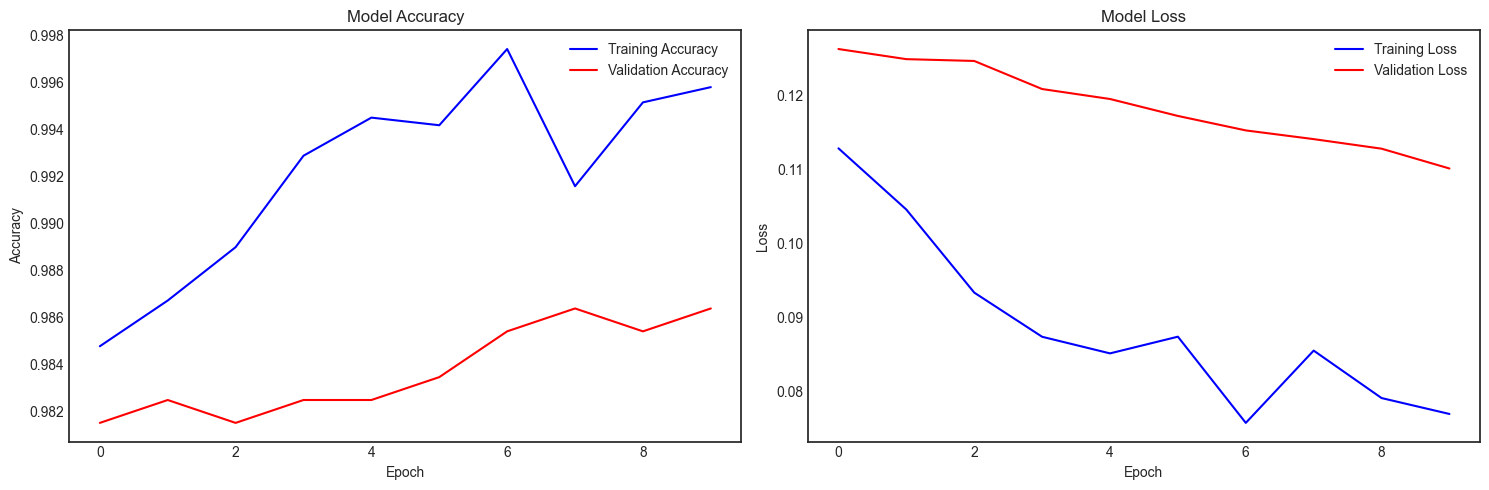

In [97]:
plot_training_history(history_finetune_b5_v1,"efficientnetb5_v1_finetune")


Generating detailed classification report...
Inferred class names: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']
Processed batch 1
Processed batch 11
Processed batch 21
Processed batch 31

✅ Classification Report:

              precision    recall  f1-score   support

         CaS       0.99      0.99      0.99       160
         CoS       0.99      1.00      0.99       149
         Gum       0.99      0.98      0.99       120
          MC       0.98      0.97      0.97       180
          OC       0.98      0.97      0.98       108
         OLP       0.98      0.98      0.98       180
          OT       0.99      1.00      1.00       131

    accuracy                           0.99      1028
   macro avg       0.99      0.99      0.99      1028
weighted avg       0.99      0.99      0.99      1028



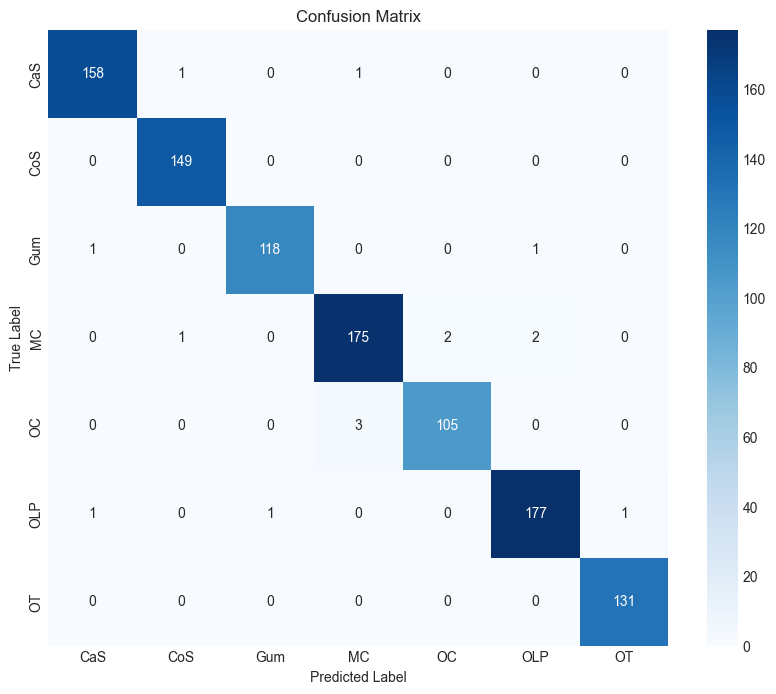

In [98]:
evaluate_and_plot_confusion_matrix(model_b5_v1, test_data, model_name="efficientnetb5_v1_finetune")

# **I Will Try To Fine Tune  and UnFroze the last 50 layers as stage two fine tune**


In [99]:
model_b5_v1.load_weights("model_checkpoint/all_epochs/efficientnetb5_v1_finetune_stage1_checkpoint.h5")

model_b5_v1.summary()


Model: "efficientnetb5_feature_extraction_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer_b5_v1 (InputLayer)  [(None, 256, 256, 3  0          []                               
                                )]                                                                
                                                                                                  
 efficientnetb5 (Functional)    (None, 8, 8, 2048)   28513527    ['input_layer_b5_v1[0][0]']      
                                                                                                  
 global_avg_pool (GlobalAverage  (None, 2048)        0           ['efficientnetb5[0][0]']         
 Pooling2D)                                                                                       
                                                               

In [100]:
model_b5_v1.layers[1].trainable = True
for layer in model_b5_v1.layers[1].layers[:-50]:
    layer.trainable = False

In [101]:
for layer_number, layer in enumerate(model_b5_v1.layers[1].layers):
    print(f"{layer_number} - {layer.name} - {layer.trainable}")

0 - input_1 - False
1 - rescaling - False
2 - normalization - False
3 - rescaling_1 - False
4 - stem_conv_pad - False
5 - stem_conv - False
6 - stem_bn - False
7 - stem_activation - False
8 - block1a_dwconv - False
9 - block1a_bn - False
10 - block1a_activation - False
11 - block1a_se_squeeze - False
12 - block1a_se_reshape - False
13 - block1a_se_reduce - False
14 - block1a_se_expand - False
15 - block1a_se_excite - False
16 - block1a_project_conv - False
17 - block1a_project_bn - False
18 - block1b_dwconv - False
19 - block1b_bn - False
20 - block1b_activation - False
21 - block1b_se_squeeze - False
22 - block1b_se_reshape - False
23 - block1b_se_reduce - False
24 - block1b_se_expand - False
25 - block1b_se_excite - False
26 - block1b_project_conv - False
27 - block1b_project_bn - False
28 - block1b_drop - False
29 - block1b_add - False
30 - block1c_dwconv - False
31 - block1c_bn - False
32 - block1c_activation - False
33 - block1c_se_squeeze - False
34 - block1c_se_reshape - False
3

In [102]:
model_b5_v1.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(lr=1e-4),
    metrics=["accuracy"]
)

callbacks_finetune_stage2_b5_v1 = [
    get_tensorboard_callback(base_dir="logs", experiment_name="efficientnetb5_v1_finetune"),
    get_early_stopping_callback(monitor="val_loss", patience=5),
    *get_model_checkpoint_callbacks(
        model_name="efficientnetb5_v1_finetune_stage2",
        checkpoint_dir="model_checkpoint"
    ),
    get_reduce_lr_on_plateau_callback(monitor="val_loss", factor=0.3, patience=5, min_lr=1e-8)
]


[INFO] Saving TensorBoard logs to: logs\efficientnetb5_v1_finetune\20250710-031757


c:\Users\worki\anaconda3\envs\TF3070\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [103]:
TOTAL_EPOCHS=history_finetune_b5_v1.epoch[-1]+10
history_finetune_b5_v1 = model_b5_v1.fit(
    train_data,
    validation_data=validation_data,
    epochs=TOTAL_EPOCHS,
    initial_epoch=history_finetune_b5_v1.epoch[-1],
    steps_per_epoch=len(train_data),
    validation_steps=len(validation_data),
    callbacks=callbacks_finetune_stage2_b5_v1
)


Epoch 29/38
97/97 [==============================] - ETA: 0s - loss: 0.2826 - accuracy: 0.9226
Epoch 29: saving model to model_checkpoint\all_epochs\efficientnetb5_v1_finetune_stage2_checkpoint.h5

Epoch 29: val_loss improved from inf to 0.11765, saving model to model_checkpoint\efficientnetb5_v1_finetune_stage2_best.h5
97/97 [==============================] - 44s 295ms/step - loss: 0.2826 - accuracy: 0.9226 - val_loss: 0.1177 - val_accuracy: 0.9815 - lr: 1.0000e-04
Epoch 30/38
97/97 [==============================] - ETA: 0s - loss: 0.1227 - accuracy: 0.9776
Epoch 30: saving model to model_checkpoint\all_epochs\efficientnetb5_v1_finetune_stage2_checkpoint.h5

Epoch 30: val_loss improved from 0.11765 to 0.10786, saving model to model_checkpoint\efficientnetb5_v1_finetune_stage2_best.h5
97/97 [==============================] - 25s 253ms/step - loss: 0.1227 - accuracy: 0.9776 - val_loss: 0.1079 - val_accuracy: 0.9844 - lr: 1.0000e-04
Epoch 31/38
97/97 [==============================] - E

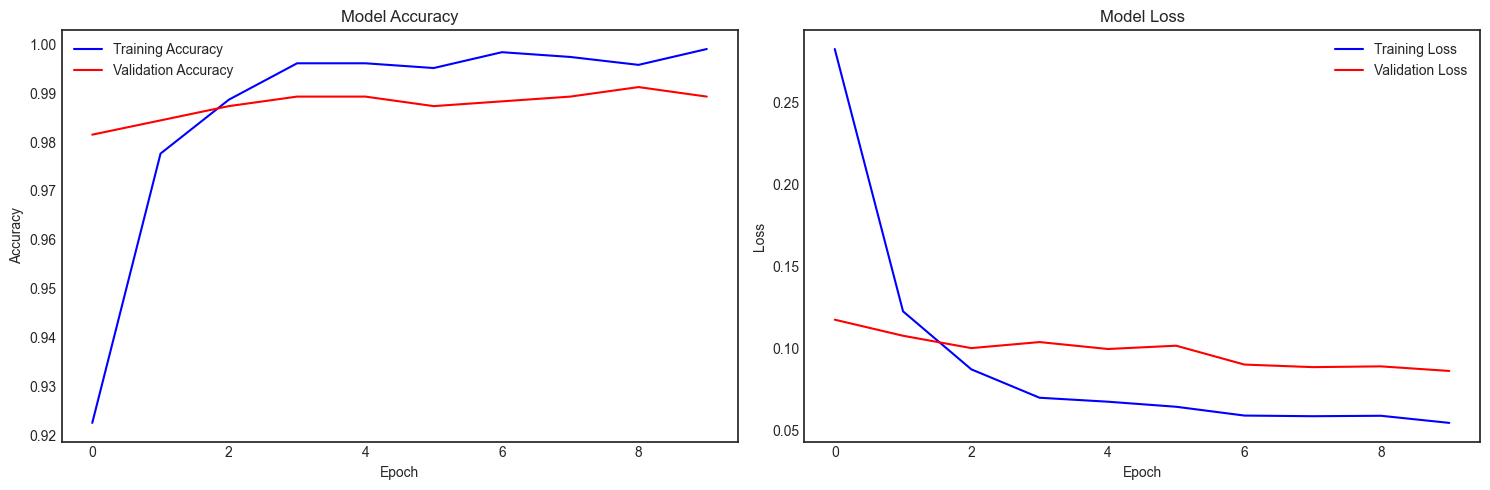

In [104]:
plot_training_history(history_finetune_b5_v1,"efficientnetb5_v1_finetune_stage2")


Generating detailed classification report...
Inferred class names: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']
Processed batch 1
Processed batch 11
Processed batch 21
Processed batch 31

✅ Classification Report:

              precision    recall  f1-score   support

         CaS       1.00      0.99      1.00       160
         CoS       1.00      1.00      1.00       149
         Gum       1.00      1.00      1.00       120
          MC       0.99      0.99      0.99       180
          OC       0.99      0.98      0.99       108
         OLP       1.00      1.00      1.00       180
          OT       0.99      1.00      1.00       131

    accuracy                           1.00      1028
   macro avg       1.00      1.00      1.00      1028
weighted avg       1.00      1.00      1.00      1028



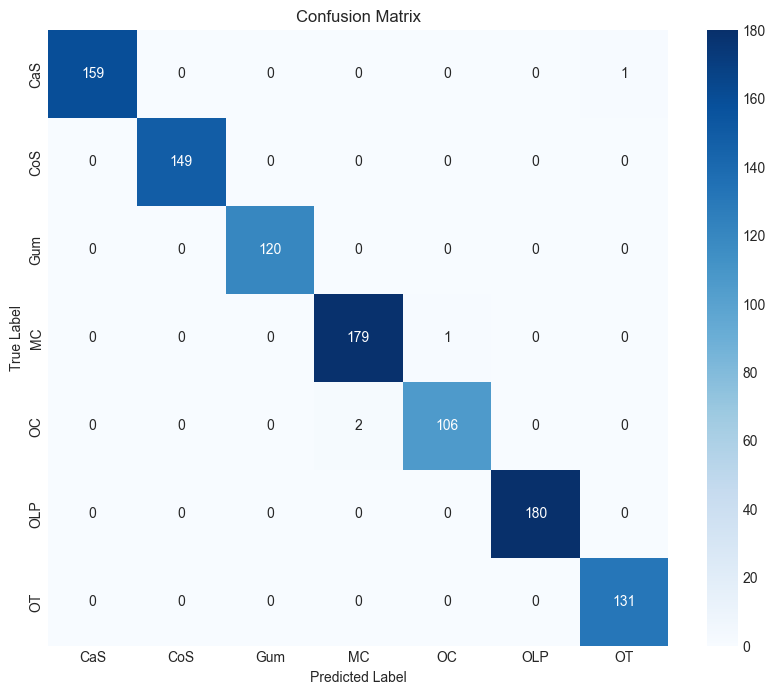

In [105]:
evaluate_and_plot_confusion_matrix(model_b5_v1, test_data, model_name="efficientnetb5_v1_finetune_stage2")